<a href="https://colab.research.google.com/github/SetuKaswan/zeotap/blob/main/Setu_Kaswan_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [25]:
customers_url = 'https://raw.githubusercontent.com/SetuKaswan/zeotap/refs/heads/main/Customers.csv'
products_url = 'https://raw.githubusercontent.com/SetuKaswan/zeotap/refs/heads/main/Products.csv'
transactions_url = 'https://raw.githubusercontent.com/SetuKaswan/zeotap/refs/heads/main/Transactions.csv'

In [26]:
from urllib.request import urlretrieve
urlretrieve(customers_url, 'customers.csv')
urlretrieve(products_url, 'products.csv')
urlretrieve(transactions_url, 'transactions.csv')

('transactions.csv', <http.client.HTTPMessage at 0x7d1532acb310>)

In [30]:
cutomers_df = pd.read_csv('customers.csv')
products_df = pd.read_csv('products.csv')
transactions_df = pd.read_csv('transactions.csv')

# **Data Preparation and Feature Engineering**

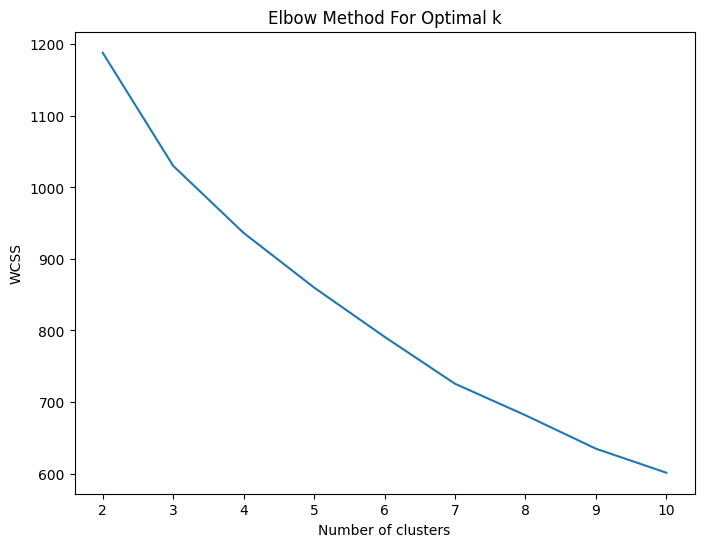

Davies-Bouldin Index: 1.703038728640497


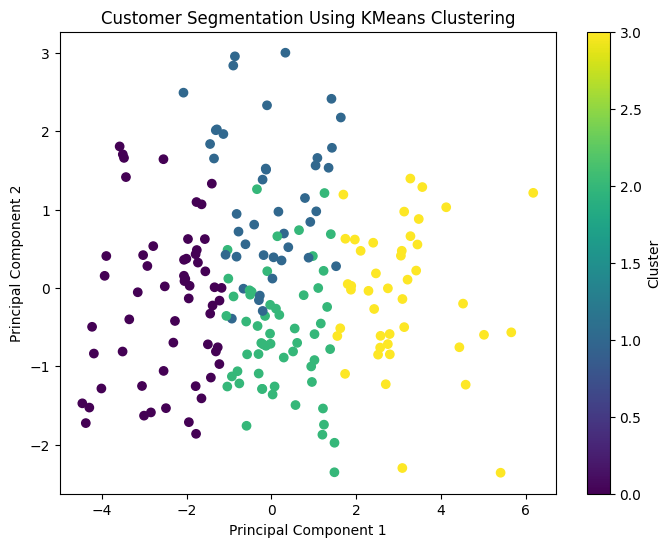

In [31]:
def create_customer_features(customers_df, transactions_df, products_df):
    customer_metrics = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Number of transactions
        'TotalValue': 'sum',      # Total spend
        'Quantity': 'sum',        # Total items bought
        'ProductID': lambda x: len(set(x))  # Unique products bought
    }).rename(columns={
        'TransactionID': 'transaction_count',
        'TotalValue': 'total_spend',
        'Quantity': 'total_items',
        'ProductID': 'unique_products'
    })

    customer_metrics['avg_order_value'] = customer_metrics['total_spend'] / customer_metrics['transaction_count']

    product_categories = products_df[['ProductID', 'Category']].set_index('ProductID')
    txn_with_categories = transactions_df.merge(product_categories, on='ProductID')

    category_preferences = pd.get_dummies(txn_with_categories['Category'])
    category_preferences = category_preferences.mul(txn_with_categories['Quantity'], axis=0)
    category_preferences = category_preferences.groupby(txn_with_categories['CustomerID']).sum()

    customer_features = pd.merge(
        customer_metrics,
        category_preferences,
        left_index=True,
        right_index=True,
        how='left'
    )

    return customer_features


customer_features = create_customer_features(customers_df, transactions_df, products_df)

customer_features_cleaned = customer_features.copy()

customer_features_cleaned = customer_features_cleaned.fillna(customer_features_cleaned.mean())
#data scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features_cleaned)

# Apply KMeans clustering
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

#plot the Elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal_clusters = 4

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

customer_features['Cluster'] = cluster_labels
#calc davis bouldin index
db_index = davies_bouldin_score(scaled_features, cluster_labels)
print(f'Davies-Bouldin Index: {db_index}')

#visualize the clusters
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

clustered_data = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
clustered_data['Cluster'] = cluster_labels
#plotting
plt.figure(figsize=(8, 6))
plt.scatter(clustered_data['PC1'], clustered_data['PC2'], c=clustered_data['Cluster'], cmap='viridis')
plt.title('Customer Segmentation Using KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()